In [2]:
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt

from metpy.units import units
import metpy.calc as mpcalc
import metpy.plots as plots
from siphon.simplewebservice.wyoming import WyomingUpperAir

The code below attempts to use sensible defaults, but you can tweak it to your liking.

In [3]:
def plot_sounding(date, station, t_color, td_color, figsize, xaxis, yaxis,
                  title, filename):
    """A function for plotting soundings in the spirit of SNPROF."""

    def pull_out_data(df, var):
        return df[var].values * units(df.units[var])

    def force_monotonic(p1, T1, Td1, u1, v1):
        p = [p1[0].m]
        T = [T1[0].m]
        Td = [Td1[0].m]
        u = [u1[0].m]
        v = [v1[0].m]
        for k, pk in enumerate(p1[1:], 1):
            if p1[k] < p1[k-1]:
                p.append(pk.m)
                T.append(T1[k].m)
                Td.append(Td1[k].m)
                u.append(u1[k].m)
                v.append(v1[k].m)
        p = np.array(p) * units('hPa')
        T = np.array(T) * units('degC')
        Td = np.array(Td) * units('degC')
        u = np.array(u) * units('kt')
        v = np.array(v) * units('kt')
        return p, T, Td, u, v
    
    # Get the sounding data
    df = WyomingUpperAir.request_data(date, station)
    p = pull_out_data(df, 'pressure')
    T = pull_out_data(df, 'temperature')
    Td = pull_out_data(df, 'dewpoint')
    u = pull_out_data(df, 'u_wind')
    v = pull_out_data(df, 'v_wind')

    p, T, Td, u, v = force_monotonic(p, T, Td, u, v)
   
    # Make the plot
    # Part 1: Create figure
    fig = plt.figure(figsize=figsize)

    # Part 2: We will put a Skew-T in this figure
    skew = plots.SkewT(fig, rotation=45)

    # Part 3: Plot the observed temperature and dewpoint profiles
    skew.plot(p, T, color=t_color)
    skew.plot(p, Td, color=td_color)

    # Part 4a: Reduce the number of wind observations in the profile, in this
    #          case by picking 40 roughly equally spaced obs...
    interval = np.logspace(np.log10(yaxis[1]),np.log10(yaxis[0]),40) * units.hPa
    idx = mpcalc.resample_nn_1d(p, interval)

    # Part 4b: And plot the filtered winds
    skew.plot_barbs(p[idx], u[idx], v[idx])

    # Part 5: Set the limits on the axes
    skew.ax.set_xlim(*xaxis)
    skew.ax.set_ylim(*yaxis)

    # Part 6: Add the standard lines to the Skew T
    skew.plot_dry_adiabats(t0=list(range(140,460,10)) * units.degK)
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()

    # Part 7: Add the parcel trajectory.  Feel free to comment out.
    traj = mpcalc.parcel_profile(p, T[0], Td[0])
    skew.plot(p, traj, color='k')
    skew.shade_cape(p, T, traj)
    skew.shade_cin(p, T, traj)

    # Part 8: Add title and show (or save, using plt.savefig) the result.
    plt.title(title)
    if filename == 'screen':
        plt.show()
    else:
        plt.savefig(filename)

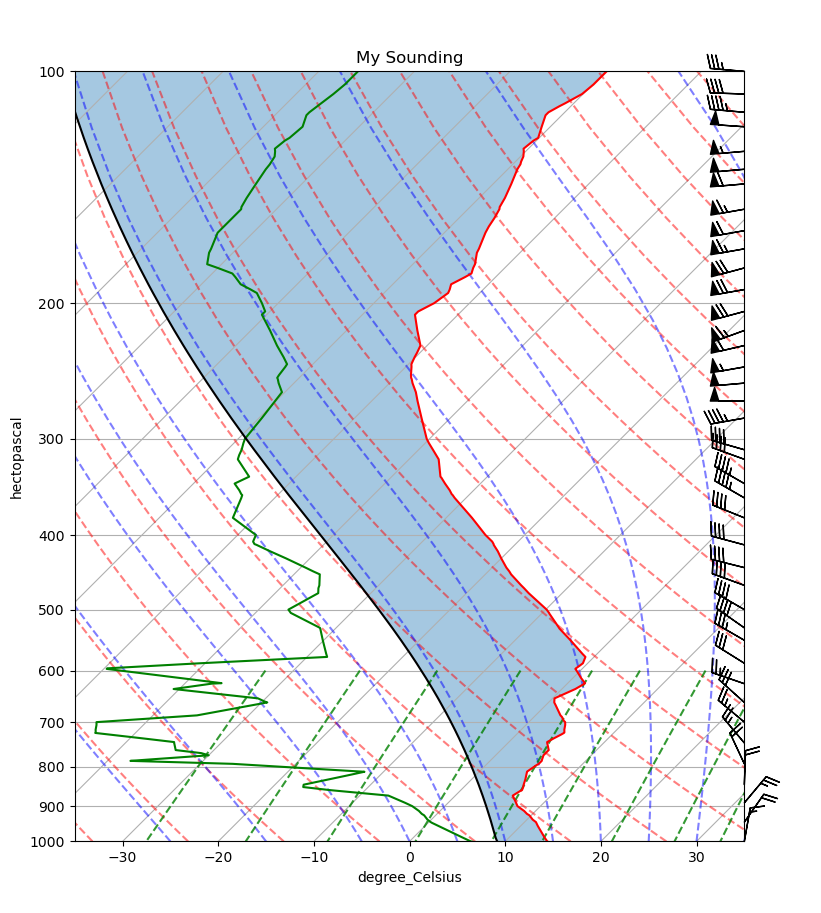

In [5]:
settings = {
    'date': datetime(2024, 9, 3, 12),
    'station': 'OKX',
    't_color': 'red',
    'td_color': 'green',
    'figsize': (10, 10),
    'xaxis': (-35, 35),
    'yaxis': (1000, 100),
    'title': 'My Sounding',
    'filename': 'screen'
}


plot_sounding(**settings)